# Hierarchical nucleation of deep networks

In [1]:
# Compile the cython extension locally

!python setup_cython.py build_ext --inplace ;


running build_ext


In [2]:
# Import libraries and source code to run the analysis

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score
from data_sets import Data_sets
%load_ext autoreload
%autoreload 2


In [8]:
# Download and unzip the data from figshare

!curl -o dist_imagenet90k_r152.tar.gz https://ndownloader.figshare.com/files/22903688?private_link=6c875e9f4a31bfd79794
    
!tar -xzf dist_imagenet90k_r152.tar.gz
    
# If the above does not work, please download the data manually at the link https://figshare.com/s/6c875e9f4a31bfd79794


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  148M  100  148M    0     0  1113k      0  0:02:16  0:02:16 --:--:-- 1131k39.1M    0     0  1091k      0  0:02:19  0:00:36  0:01:43 1093k


In [3]:
sampled_images_id = None
animal_artifacts = None # TODO: import these files

In [10]:
data_folder = 'maxk_30'

#checkpoints = [0, 1, 10, 34, 97, 142, 145, 148, 151, 152, 153]
checkpoints = [0, 1, 10, 34, 142, 151, 152, 153]

labels = np.repeat(np.arange(300), 300)

ds = Data_sets()

for cp in checkpoints:
    distances = np.load(data_folder + '/layer_{}.npz'.format(cp))
    ds.add_one_dataset(distances=(distances['dist'], distances['index']), labels = labels, maxk = 30)
    

In [5]:

overlap_gt = ds.return_label_overlap_mean()


computing overlap for dataset  0
computing overlap for dataset  1
computing overlap for dataset  2
computing overlap for dataset  3
computing overlap for dataset  4
computing overlap for dataset  5
computing overlap for dataset  6
computing overlap for dataset  7


Text(0.5, 0, 'checkpoints')

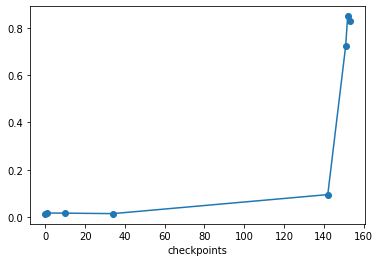

In [6]:
# TODO: improve graph
plt.plot(checkpoints, overlap_gt, '-o')
plt.xlabel('checkpoints')

In [11]:
### Compute intrisic dimension across all layers ###
ds.compute_id(fraction = 0.95, decimation = 1)

computing id of layer  0
computing id of layer  1
computing id of layer  2
computing id of layer  3
computing id of layer  4
computing id of layer  5
computing id of layer  6
computing id of layer  7
computing id of layer  8
computing id of layer  9
computing id of layer  10


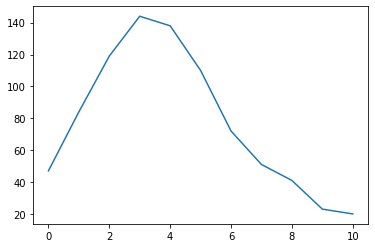

In [12]:
plt.plot(ds.ids)

In [ ]:
### Compute density of each point across all layers ###
ds.compute_density_kNN(k= 30)

In [13]:
### Find density peaks and saddle points between them for all layers ###
ds.compute_clustering(Z = 1.65, halo = False)

Z = 1.65, halo = False
computing clustering for dataset  0
computing clustering for dataset  1
computing clustering for dataset  2
computing clustering for dataset  3
computing clustering for dataset  4
computing clustering for dataset  5
computing clustering for dataset  6
computing clustering for dataset  7
computing clustering for dataset  8
computing clustering for dataset  9
computing clustering for dataset  10
Z = 1.65, halo = False


In [14]:
# TODO: to be finished
### Save density peaks and saddle points for of the layers considered

ds.data_sets[0].out_bord

#np.savetxt()

array([[-295.81, -217.06, -294.81, -217.31],
       [-217.06, -295.81, -294.81, -255.76],
       [-294.81, -294.81, -295.81, -217.76],
       [-217.31, -255.76, -217.76, -295.81]])

In [15]:

ARIs_classes = []
#ARIs_macro = []

for d in ds.data_sets:
    ARI = adjusted_rand_score(d.labels, labels)
    ARIs_classes.append(ARI)
    
    

Text(0, 0.5, 'ARI')

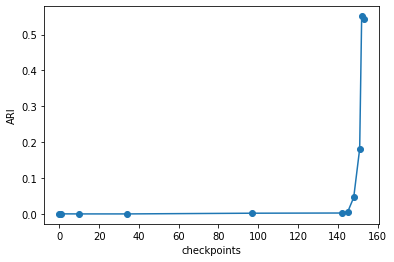

In [16]:

plt.plot(checkpoints, ARIs_classes, '-o')
plt.xlabel('checkpoints')
plt.ylabel('ARI')